In [3]:
# Mounting the google colab drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np

#comments_to_score
comments_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/jigsaw-toxic-severity-rating/comments_to_score.csv")

#vaidation_Data_set
val_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/jigsaw-toxic-severity-rating/validation_data.csv")

#train_dataset_from_first_Kaggle_competition
train_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/jigsaw-toxic-comment-classification-challenge/train.csv")

In [5]:
#category labels
cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

#get the toxicity score based on the sum of all sub categories
train_df['toxicity'] = train_df[cols].sum(axis=1)

In [6]:
train_df['toxicity'].value_counts()

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: toxicity, dtype: int64

Text(0.5, 1.0, 'Toxicity in Comments')

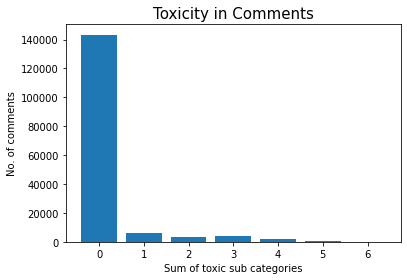

In [7]:
import matplotlib.pyplot as plt
plt.bar(x=train_df['toxicity'].value_counts().index,height=train_df['toxicity'].value_counts())
plt.xlabel("Sum of toxic sub categories")
plt.ylabel("No. of comments")
plt.title("Toxicity in Comments", fontsize=15)

### Length of comments with no toxicity is 143346 so it's highly imbalanced. Lets try to resample this to get equal portion of non-toxic and toxic comments

In [8]:
#len of comments with no toxicity is 143346 so it's highly imbalanced.
#let's dowsample this to the sane as comments with some toxic elements
tox_len = len(train_df[train_df['toxicity']>0])

#undersample non-toxic comments
df_undersample = train_df[train_df['toxicity'] == 0].sample(n=tox_len, random_state=46)  # take non toxic comments
df_new = pd.concat([train_df[train_df['toxicity'] > 0], df_undersample])  # make new df
df_new.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxicity
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,1
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,1
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,4
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,3


In [9]:
#remove id the toxicity score as that was only for the purpose of evaluating the data distribution
#train_data = df_new.drop(['id','toxicity'],axis = 1)

In [10]:
import sklearn

In [11]:
#shuffle the toxic and non-toxic comments as current the data is segmented with top 16225 as toxic and bottom 16225 as non-toxic
from sklearn.utils import shuffle

df_shuffled=sklearn.utils.shuffle(df_new)
df_shuffled.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxicity
34283,5b833907b805a963,"""\n\nThanks. I am only working on animals now,...",0,0,0,0,0,0,0
91502,f4a9a69f34c81b91,your grammar is retarded two,1,0,0,0,1,0,2
93045,f8c2f29db819dda9,s\n\nNow mr dictator you response is rubbish. ...,1,0,0,0,0,0,1
127075,a79c26ad9086e35a,And its me you fat bitch stop deleting my imag...,1,0,1,0,1,0,3
158386,ecec40d9e46b478d,"""\nYea. It is weird. ;) Man, that does suck. H...",1,0,1,0,0,0,2


# Text cleaning

In [12]:
import nltk

In [13]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [14]:
#function for text cleaning

from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

import re
def text_cleaning(text):
    forbidden_words = set(stopwords.words('english'))
    if text:
        text = ' '.join(text.split('.'))
        text = re.sub('\/',' ',text)
        text = re.sub(r'\\',' ',text)
        text = re.sub(r'((http)\S+)','',text)
        text = re.sub('\s+', ' ', text)  # will remove more than one whitespace character
        text = re.sub(r'\s+', ' ', re.sub('[^A-Za-z]', ' ', text.strip().lower())).strip()
        text = re.sub(r'\W+', ' ', text.strip().lower()).strip()
        
        """ Replaces url address with "url" """
        text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
        text = re.sub(r'#([^\s]+)', r'\1', text)
        
        #remove multiple toxic words
        text = re.sub(r'(fuckfuck)','fuck fuck ',text)
        text = re.sub(r'(f+)( *)([u|*]+)( *)([c|*]+)( *)(k)+','fuck',text)
        text = re.sub(r'(s+ *h+ *i+ *t+)','shit',text)
        text = re.sub(r'([a|@][$|s][s|$])','ass',text)
        text = re.sub(r'(\bfuk\b)','fuck',text)
        text = re.sub(r'(\bpennnis\b)','penis',text)
        text = re.sub(r'(\bfggt\b)','faggot',text)
        text = re.sub(r'(\bfag\b)','faggot',text)
        
        #replaces abreviations
        text = re.sub(r"what's", "what is ",text)    
        text = re.sub(r"\'ve", " have ",text)
        text = re.sub(r"can't", "cannot ",text)
        text = re.sub(r"n't", " not ",text)
        text = re.sub(r"i'm", "i am ",text)
        text = re.sub(r"\'re", " are ",text)
        text = re.sub(r"\'d", " would ",text)
        text = re.sub(r"\'ll", " will ",text)
        text = re.sub(r"\'scuse", " excuse ",text)
        text = re.sub(r"\'s"," ",text)
        
        #remove unicode strings
        """ Removes unicode strings like "\u002c" and "x96" """
        text = re.sub(r'(\\u[0-9A-Fa-f]+)',r' ', text)       
        text = re.sub(r'[^\x00-\x7f]',r' ',text)
        
        """ Replaces "@user" with "atUser" """
        text = re.sub('@[^\s]+','atUser',text)
        
        text = [word for word in text.split() if word not in forbidden_words]
        
        
        
        #lemmatize words
        lemmatizer = WordNetLemmatizer()
        text = [lemmatizer.lemmatize(word) for word in text]
        return text
    return []

In [15]:
df_shuffled['comment_text'] = df_shuffled['comment_text'].apply(lambda x: ' '.join(text_cleaning(x)))

# Building the model

In [16]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [17]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
vocab_size = 20000
embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 26000

In [19]:
sentences = df_shuffled['comment_text']
labels = df_shuffled[cols]

In [20]:
labels

,toxic,severe_toxic,obscene,threat,insult,identity_hate
34283,0,0,0,0,0,0
91502,1,0,0,0,1,0
93045,1,0,0,0,0,0
127075,1,0,1,0,1,0
158386,1,0,1,0,0,0
...,...,...,...,...,...,...
42177,0,0,0,0,0,0
157679,1,1,1,0,1,0
51943,0,0,0,0,0,0
36015,0,0,0,0,0,0


In [21]:
#split the data into train and test sets
training_sentences = sentences[0:training_size].tolist()
testing_sentences = sentences[training_size:].tolist()
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [22]:
len(training_sentences)

26000

In [23]:
len(testing_sentences)

6450

In [24]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [25]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [26]:
print(f"training X shape: {training_padded.shape}")
print(f"training Y shape: {training_labels.shape}")
print(f"testing X shape: {testing_padded.shape}")
print(f"testing Y shape: {testing_labels.shape}")

training X shape: (26000, 100)
training Y shape: (26000, 6)
testing X shape: (6450, 100)
testing Y shape: (6450, 6)


In [44]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(6, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 128)          2560000   
                                                                 
 global_average_pooling1d_3   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 6)                 390       
                                                                 
Total params: 2,568,646
Trainable params: 2,568,646
Non-trainable params: 0
_________________________________________________________________


In [46]:
num_epochs = 5
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/5
813/813 - 6s - loss: 0.3308 - accuracy: 0.9379 - val_loss: 0.2461 - val_accuracy: 0.9740 - 6s/epoch - 8ms/step
Epoch 2/5
813/813 - 5s - loss: 0.2172 - accuracy: 0.9707 - val_loss: 0.2057 - val_accuracy: 0.9740 - 5s/epoch - 6ms/step
Epoch 3/5
813/813 - 5s - loss: 0.1850 - accuracy: 0.9704 - val_loss: 0.1962 - val_accuracy: 0.9736 - 5s/epoch - 6ms/step
Epoch 4/5
813/813 - 5s - loss: 0.1684 - accuracy: 0.9602 - val_loss: 0.2033 - val_accuracy: 0.9674 - 5s/epoch - 6ms/step
Epoch 5/5
813/813 - 5s - loss: 0.1548 - accuracy: 0.9235 - val_loss: 0.1971 - val_accuracy: 0.9313 - 5s/epoch - 6ms/step


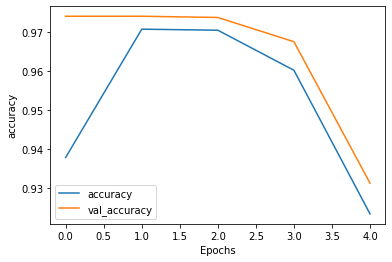

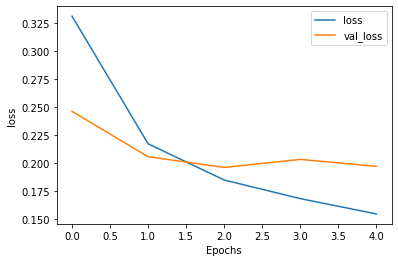

In [47]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [49]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))

thanks working animal would already great animal bot need long time write kingdom think write see thing file bot make link scientific classification able change <OOV> <OOV> guess main difference nl en case use taxobox section binomial always taxobox section binomial parens guess somewhere code change taxobox section binomial simple taxobox section binomial taxobox section binomial parens think able change kind thing ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?


In [50]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(20000, 128)


# Validating the data

In [51]:
#combine val_data_df into single comments list
less_toxic=val_df['less_toxic'].tolist()
len(less_toxic)

30108

In [52]:
#more_toxic_comments
more_toxic=val_df['more_toxic'].tolist()

#less_toxic_comments_len
len(more_toxic)

30108

60216

In [54]:
#clean less toxic and more toxic comments
less_toxic_cleaned = [' '.join(text_cleaning(line)) for line in less_toxic]
more_toxic_cleaned = [' '.join(text_cleaning(line)) for line in more_toxic]

In [55]:
#all_comments
all_comments = less_toxic_cleaned + more_toxic_cleaned
len(all_comments)

60216

In [57]:
sequences = tokenizer.texts_to_sequences(all_comments)

In [59]:
padded_vl = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [60]:
y_pred = model.predict(padded_vl)

In [62]:
#taking the sums of the value predictions for each of the individual categories
y_pred_scores = np.sum(y_pred,axis=0)  

In [65]:
less_toxic_score=y_pred_scores[:30108]
more_toxic_score=y_pred_scores[30108:]

In [67]:
#comparing the results of the validation set:
result=[]
for i in range(len(less_toxic_score)):
    if less_toxic_score[i]<more_toxic_score[i]:
        result.append(1)
    else:
        result.append(0)

In [69]:
val_df['less_toxic_score']=less_toxic_score
val_df['more_toxic_score']=more_toxic_score
val_df['result']=result

In [70]:
val_df

,worker,less_toxic,more_toxic,less_toxic_score,more_toxic_score,result
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,2.373808,0.790641,0
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...,0.012887,0.966720,1
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu...",0.080561,0.002985,0
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...,1.060289,3.351526,1
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist",2.118685,1.306787,0
...,...,...,...,...,...,...
30103,461,I'm sorry. I'm not an admin. I will give you t...,get out my large penis,0.153869,1.775007,1
30104,527,I'm sorry. I'm not an admin. I will give you t...,get out my large penis,0.153869,1.775007,1
30105,352,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook,0.304213,2.388557,1
30106,311,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook,0.304213,2.388557,1


In [71]:
val_df['result'].value_counts(normalize=True)

1    0.680284
0    0.319716
Name: result, dtype: float64